#Important Note:
This notebook references the following [notebook](https://www.kaggle.com/code/dikshabhati2002/song-lyrics-generator/notebook)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

# Data Acquisition


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
file_path = '/content/gdrive/My Drive/CSC413/lyrics-data.csv/lyrics-data.csv' 

In [ ]:
data = pd.read_csv(file_path)

In [ ]:
data.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [ ]:
data.drop(['ALink', 'SLink'],axis=1,inplace=True)

In [ ]:
data.shape

(379931, 3)

In [ ]:
data['language'].value_counts()

en     191814
pt     157393
es       9917
rw       1679
it       1432
fr       1225
de        844
fi        145
sv        112
ro         97
no         89
is         86
tl         69
pl         47
gl         36
ga         32
tr         32
id         26
cy         23
su         19
af         19
sw         19
ko         17
nl         14
da         13
ca         13
et         13
ms          8
ja          7
st          7
ht          5
gd          4
ru          4
ar          4
eu          4
cs          3
ku          3
ny          3
mg          3
lg          2
jw          2
hu          2
vi          1
iw          1
sr          1
hmn         1
hr          1
fa          1
sq          1
zh          1
lv          1
sl          1
Name: language, dtype: int64

## What about getting English-only songs?

In [ ]:
data = data[data['language']=='en']

In [ ]:
data['language'].value_counts()

en    191814
Name: language, dtype: int64

Now, we have only English lyrics in our dataset!

In [ ]:
subset = data[:1400]

Take a subset to look at.

In [ ]:
subset.shape

(1400, 3)

# Data Visualization

In [ ]:
subset['Number_of_words'] = subset['Lyric'].apply(lambda x:len(str(x).split()))
subset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,SName,Lyric,language,Number_of_words
69,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,299
86,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en,161
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,159
111,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,175
140,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,215


##How does the subset statistics look?

In [ ]:
subset['Number_of_words'].describe()

count    1400.000000
mean      418.931429
std       195.621704
min         8.000000
25%       279.750000
50%       399.000000
75%       536.250000
max      1495.000000
Name: Number_of_words, dtype: float64

Average song lyrics word count for the subset is 418, with a max count of 1495, min of 8.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

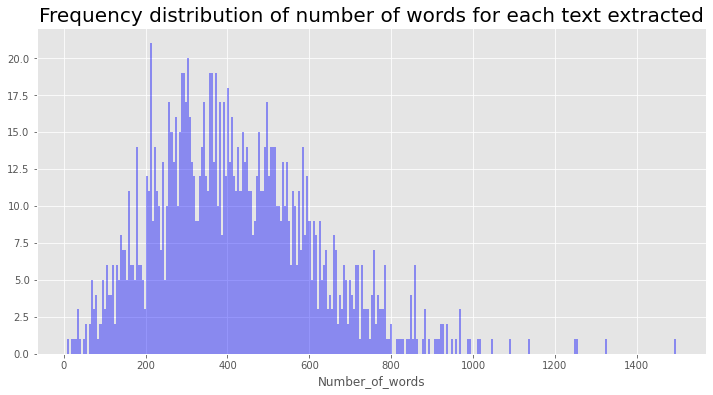

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(subset['Number_of_words'],kde = False,color="blue",bins=300)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

The distribution appears to be unimodal around the mean of 418, with some outliers in the >1000 word count range.

##How about the entire batch?

In [ ]:
data['Number_of_words'] = data['Lyric'].apply(lambda x:len(str(x).split()))
data.head()

,SName,Lyric,language,Number_of_words
69,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,299
86,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en,161
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,159
111,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,175
140,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,215


In [ ]:
data['Number_of_words'].describe()

count    191814.000000
mean        250.229159
std         159.288438
min           1.000000
25%         147.000000
50%         211.000000
75%         304.000000
max        3422.000000
Name: Number_of_words, dtype: float64

When examining all English songs, we can see a more normal looking distribution for what we might expect from song lyrics. Namely, the mean is a more modest 250, but of course, the max and min will be more extreme given the larger dataset. Nevertheless, the standard deviation is lower than the subset, as expected.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

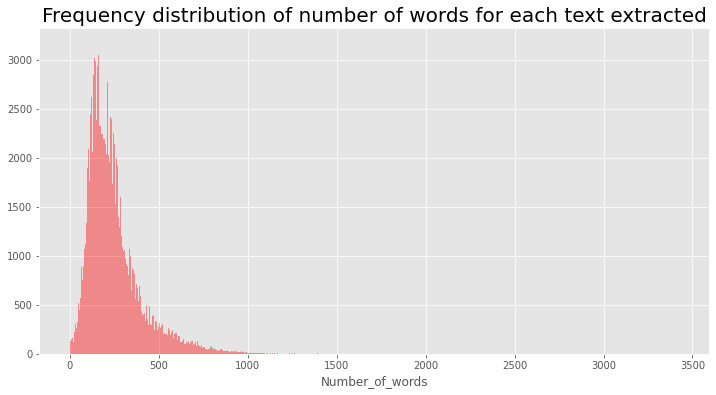

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="red",bins=1000)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

Once again, we see a unimodal distribution centered around the mean of 250, but with a longer right hand side tail (as there exists outliers in the >1000 word count range).

##How do we deal with outliers?

In [ ]:
data = data[data['Number_of_words'] <= 800]
data = data[data['Number_of_words'] >= 10]

We could choose to ignore outliers in the data, based on an arbitrary threshold (I picked a min of 10 words, and a max of 800 here).

In [ ]:
data['Number_of_words'].describe()

count    189413.000000
mean        242.793494
std         139.486299
min          10.000000
25%         147.000000
50%         210.000000
75%         300.000000
max         800.000000
Name: Number_of_words, dtype: float64

The total count still remains high, but now our standard deviation is lower.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

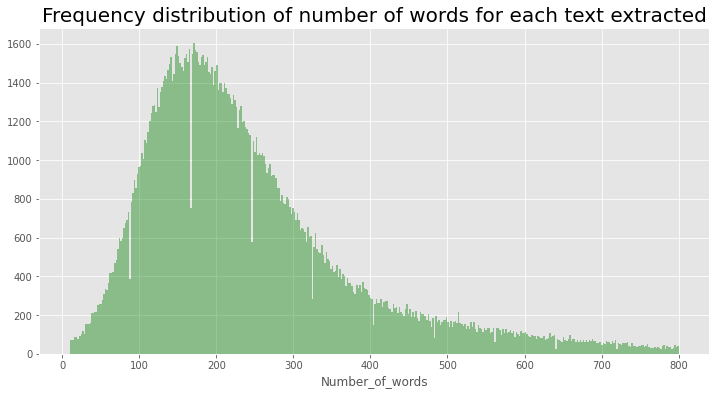

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="green",bins=400)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

This data modification results in a more normal looking dataset.